# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
from sparse_field_lib import load_data

In [3]:
import matplotlib.pyplot as plt
import torch

from bliss.datasets import sdss
from bliss.models import encoder, decoder
from bliss import sleep

In [4]:
sdss_dir = '/home/imendoza/bliss/data/sdss/'

In [5]:
device = 'cuda:4'

# Load data

In [6]:
sdss_data = sdss.SloanDigitalSkySurvey(
    sdss_dir=sdss_dir,
    run=94,
    camcol=1,
    fields=(12,),
    bands=range(5),
    overwrite_cache=True,
    overwrite_fits_cache=True,
)

In [7]:
image, fits_file, wcs_list, sdss_data = load_data(sdss_dir=sdss_dir)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '19/09/98' to '1998-09-19''. [astropy.wcs.wcs]


In [8]:
wcs = wcs_list[0]

In [9]:
pt, pr = wcs.all_world2pix(fits_file['ra'][:], fits_file['dec'][:], 0)

## Look at complete image

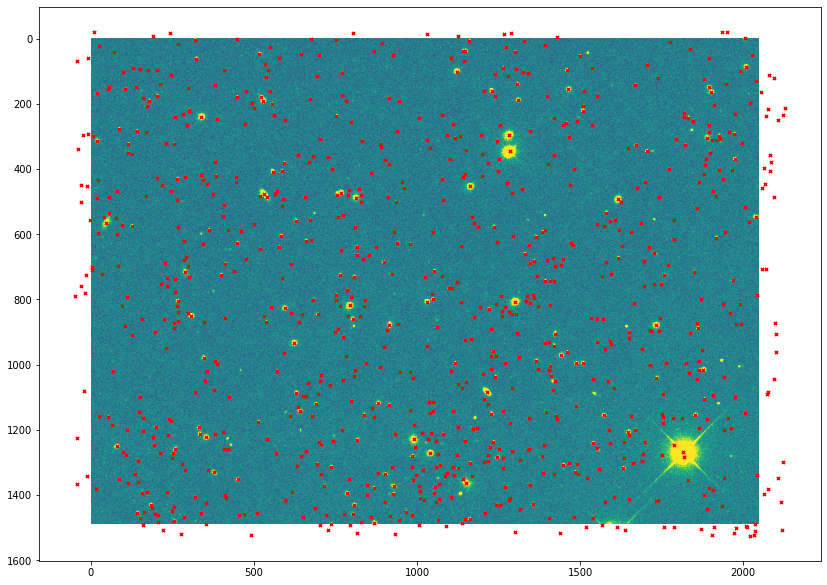

In [11]:
%matplotlib inline
plt.figure(figsize=(14,14))
vmin = np.percentile(image.flatten(), 1)
vmax = np.percentile(image.flatten(), 99)

plt.imshow(image[0], vmin=vmin, vmax=vmax)
plt.scatter(pt, pr, marker='x', color='r', s=10)


## choose one chunk

In [12]:
# prepare chunk
# i, j = np.random.randint(0, 6, size=(2))
# i,j = (1,5)
clen = 200
xlim = (450, 650)
ylim = (350, 550)
print(xlim, ylim)

chunk = image[0, ylim[0]:ylim[1], xlim[0]:xlim[1]]

pt, pr = wcs.all_world2pix(fits_file['ra'][:], fits_file['dec'][:], 0)

# restrict to 200x200 chunk 
keep = (pt > xlim[0]) & (pt < xlim[1]) & (pr < ylim[1]) & (pr > ylim[0])

# obtain star and galaxy bools for each location.
is_star = fits_file['probpsf'][:].astype(bool)
galaxy_bool = (~is_star) & keep
star_bool = is_star & keep

(450, 650) (350, 550)


In [13]:
# move image to device
slen = 200
chunks = chunk.reshape(1, 1, *chunk.shape)[:, :, :slen, :slen].to(device)
print(chunks.shape)

torch.Size([1, 1, 200, 200])


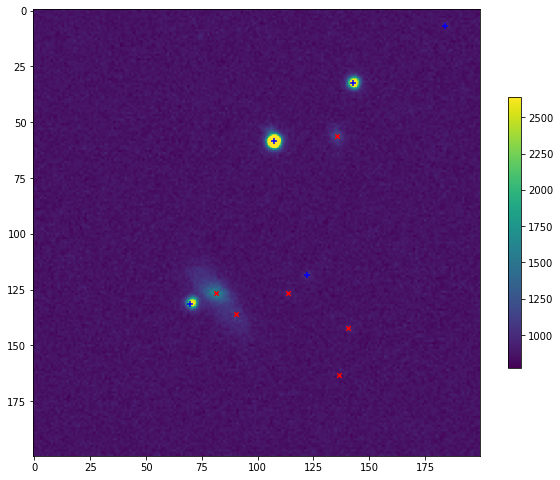

In [14]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))


p_level = 0.1
vmin = np.percentile(chunk.flatten(), p_level)
vmax = np.percentile(chunk.flatten(), 100-p_level)

# account for bia
_pt = pt - xlim[0]
_pr = pr - ylim[0]

# and show it with correct centers.
im = ax.imshow(chunk, vmin=vmin, vmax=vmax)
ax.scatter(_pt[galaxy_bool], _pr[galaxy_bool], marker='x', color='r', s=20)
ax.scatter(_pt[star_bool], _pr[star_bool], marker='+', color='b', s=30)
fig.colorbar(im, ax=ax, shrink=0.5)

## get estimate from chunk

In [15]:
# read sleep 
checkpoint_file = '/home/imendoza/bliss/models/sleep_sdss_measure.ckpt'
sleep_net= sleep.SleepPhase.load_from_checkpoint(checkpoint_file).to(device)
image_encoder = sleep_net.image_encoder
galaxy_encoder = sleep_net.galaxy_encoder

# important to turn on .eval() mode!
sleep_net = sleep_net.eval()
image_encoder = image_encoder.eval()

In [17]:
with torch.no_grad():

    tile_est = sleep_net.tile_images_map_estimate(chunks)
    sleep_net.image_decoder.background_values = (633.0, )
    
    # plot image from tile est.
    recon_image, _ = sleep_net.image_decoder.render_images(
        tile_est["n_sources"],
        tile_est["locs"],
        tile_est["galaxy_bool"],
        tile_est["galaxy_params"],
        tile_est["fluxes"],
        add_noise=False,
    )
    
    _slen = chunks.shape[-1] - image_encoder.border_padding*2
    est_params = encoder.get_full_params(tile_est, _slen)

red = galaxy
blue = star


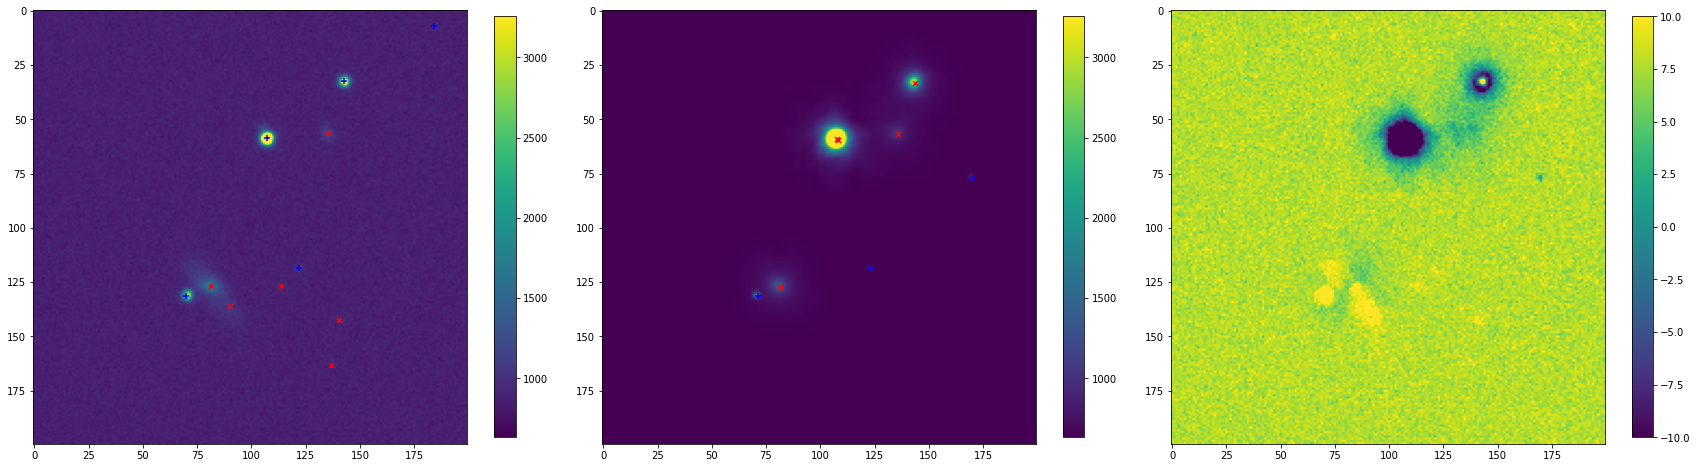

In [20]:
# plot both images side by side.
fig, axes = plt.subplots(1, 3, figsize=(24,12))
_recon_image = recon_image.detach().cpu().numpy()[0, 0]

ax1, ax2, ax3 = axes


p = 0.1
combined = np.hstack([chunk.flatten(), _recon_image.flatten()])
vmin = np.percentile(combined, p)
vmax = np.percentile(combined, 100-p)

# plot the chunk and reconstruction image side by side.
im1 = ax1.imshow(chunk, vmin=vmin, vmax=vmax)
im2 = ax2.imshow(_recon_image, vmin=vmin, vmax=vmax)
im3 = ax3.imshow( (chunk - _recon_image)/np.sqrt(chunk), vmin=-10, vmax=10)

# true image and true locations
ax1.scatter(_pt[galaxy_bool], _pr[galaxy_bool], marker='x', color='r', s=20)
ax1.scatter(_pt[star_bool], _pr[star_bool], marker='+', color='b', s=30)


# overlay the map estimate params on the full image
_locs = est_params['locs']*_slen + image_encoder.border_padding
_locs = _locs.detach().cpu().numpy()[0]
_galaxy_bool = est_params['galaxy_bool'].bool().detach().cpu().numpy()[0, :, 0]
ax2.scatter(_locs[:, 1][_galaxy_bool], _locs[:, 0][_galaxy_bool], marker='x', color='r', s=25)
ax2.scatter(_locs[:, 1][~_galaxy_bool], _locs[:, 0][~_galaxy_bool], marker='+', color='b', s=30)



# colorbar
fig.colorbar(im1, ax=ax1, shrink=0.5)
fig.colorbar(im2, ax=ax2, shrink=0.5)
fig.colorbar(im3, ax=ax3, shrink=0.5)



plt.tight_layout()

print('red = galaxy')
print('blue = star')